### CS 421 PROJECT

**Background & Objective**

In this project, you will be working with data extracted from famous recommender systems type datasets: you are provided with a large set of interactions between users (persons) and items (movies). Whenever a user "interacts" with an item, it watches the movie and gives a "rating". There are 4 possible ratings: "dislike", "neutral", "like", and "watched". The "watched" rating indicates that the user has rated the movie, but the specific rating is unknown (that means you know that the user has watched the movie, but you don't know whether they liked it).

In this exercise, we will **not** be performing the recommendation task per se. Instead, we will identify *anomalous users*. In the dataset that you are provided with, some of the data was corrupted. Whilst most of the data comes from real life user-item interactions from a famous movie rating website, some "users" are anomalous: they were generated by me according to some undisclosed procedure. Furthermore, there are **two types of anomalies** with two different generation procedures.

**Data**

You are provided with two data frames: the first one ("X") contains the interactions provided to you, and the second one ("yy") contains the labels for the users.

As you can see, the three columns in "X" correspond to the user ID, the item ID and the rating (encoded into numerical form). Thus, each row of "X" contains a single interaction. For instance, if the row "142, 152, 10" is present, this means that the user with ID 142 has given the movie 152 a positive rating of "like".

The table below shows what each numerical encoding of the rating corresponds to:

| Rating in X    | Meaning     |
| :------------- | :---------- |
| -10            | dislike     |
| 0              | neutral     |
| 10             | like        |
| 1              | watched     |

The dataframe "yy" has two columns. In the first column we have the user IDs, whilst the second column contains the labels. A label of 0 denotes a natural user (coming from real life interactions), whilst a label of 1 or 2 indicates an anomaly generated by me. The anomalies with label 1 are generated with a different procedure from the anomalies with label 2. 

For instance, if the labels matrix contains the line "142, 1", it means that ALL of the ratings given by the user with ID 142 are fake, and generated according to the first anomaly generation procedure. This means all lines in the dataframe "ratings" which start with the user ID 142 correspond to fake interactions. 

#### Evaluation

Your task is to be able to classify unseen instances as either anomalies or non anomalies (guess whether they are real users or if they were generated by me). As well as indicate which anomaly type they belong to. 

There are **far more** normal users than anomalies in the dataset, which makes this a very heavily **unbalanced dataset**. Thus, accuracy will not be a good measure of performance, since simply predicting that every user is normal will give good accuracy. Thus, we need to use some other evaluation metrics (see lecture notes from week 3). 

THE **EVALUATION METRIC** is:  THE **AUC** (AREA UNDER CURVE) for each class (thus, there are three performance measures, one for each class). The main final metric to evaluate the ranking will be the average of the three.  This means your programs should return a **score** for each user and anomaly type combination. For instance, your model's prediction for user 1200 should consist of three scores $z_0,z_1,z_2$ corresponding to the normal class and the two anomalous classes respectively. 

Every few weeks, we will evaluate the performance of each team (on a *test set with unseen labels* that I will provide) in terms of all three AUCs.

The difficulty implied by **the generation procedure of the anomalies MAY CHANGE as the project evolves: depending on how well the teams are doing, I may generate easier or harder anomalies**.

**Deliverables**

Together with this file, you are provided with a first batch of labelled examples "first_batch_multi_labels.npz". You are also provided with the test samples to rank by the next round (without labels) in the file "second_batch_multi.npz".

The **first round** will take place after recess (week 9): you must hand in your scores for the second batch before the **WEDNESDAY at NOON (15th of October)**. We will then look at the results together on the Thursday.  

We will check everyone's performance in this way every week (once on  week 10, once on week 11 and once on week 12). 

To summarise, the project deliverables are as follows:

- Before every checkpoint's deadline, you need to submit **a `.npz` file** containing a Numpy array of size $\text{number of test batch users} \times 3$, where the value of each cell corresponds to the predicted score of the user (row) belonging to the anomaly type (column). The order of rows should correspond to the user IDs. For example, if the test batch contains users 1100-2200, scores for user 1100 should be the first row (row 0), scores for user 1101 should be the second row (row 1), and so on.

- On Week 12-13 (schedule to be decided), you need to present your work in class. The presentation duration is **10 minutes** with 5 minutes of QA. 

- On Week 12, you need to submit your **Jupyter Notebook** (with comments in Markdown) and the **slides** for your presentation. 
- On week 13 you need to submit your **final report**. The final report should be 2-3 pages long (consisting of problem statement, literature review, and motivation of algorithm design) with unlimited references/appendix.

Whilst performance (expressed in terms of AUC and your ranking compared to other teams) at **each of the check points** (weeks 9 to 12 inclusive) is an **important component** of your **final grade**, the **final report** and the detail of the various methods you will have tried will **also** be very **important**. Ideally, to get perfect marks (A+), you should try at least **two supervised methods** and **two unsupervised methods**, as well as be ranked the **best team** in terms of performance. 


In addition, I will be especially interested in your **reasoning**. Especially high marks will be awarded to any team that is able to **qualitatively describe** the difference between the two anomaly types. You are also encouraged to compute statistics related to each class and describe what is different about them. 

In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data=np.load("first_batch_multi_labels.npz")

In [309]:
X=data["X"]
y=data["yy"]



XX=pd.DataFrame(X)
yy=pd.DataFrame(y)
XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)

In [310]:
XX.head()

,user,item,rating
0,1073,3,1
1,1073,15,1
2,1073,24,1
3,1073,29,1
4,1073,33,10


In [311]:
print(XX)

        user  item  rating
0       1073     3       1
1       1073    15       1
2       1073    24       1
3       1073    29       1
4       1073    33      10
...      ...   ...     ...
179751   793   845     -10
179752   793   854       1
179753   793   862       1
179754   793   886       1
179755   793   890       1

[179756 rows x 3 columns]


In [312]:
yy.rename(columns={0:"user",1:"label"},inplace=True)

In [313]:
yy.head()

,user,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [314]:
merged_df = pd.merge(XX, yy, on='user')
merged_df.head()

,user,item,rating,label
0,1073,3,1,0
1,1073,15,1,0
2,1073,24,1,0
3,1073,29,1,0
4,1073,33,10,0


In [315]:
# Calculate average rating per item
average_rating_df = merged_df.groupby('item')['rating'].mean().reset_index()

# Rename the columns
average_rating_df.columns = ['item', 'average_rating']

# Display the new DataFrame
print(average_rating_df)

      item  average_rating
0        0        3.553254
1        1        0.462470
2        2       -0.323529
3        3        1.250639
4        4        2.073593
...    ...             ...
1011  1014        2.344828
1012  1015        1.041667
1013  1016       -2.250000
1014  1017       -0.357143
1015  1018        2.697674

[1016 rows x 2 columns]


In [316]:
# Get unique values in the 'item' column
unique_items = merged_df['user'].unique()

# Display the result
print('Unique items:', unique_items)
print(len(unique_items))

Unique items: [1073  741  202 ...  264   23  793]
1100


In [317]:
user52 = merged_df[merged_df['user']== 52]
#print(user52)
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Print the DataFrame
print(user52)

# Reset display options if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

        user  item  rating  label
171171    52     0     -10      2
171172    52     1       1      2
171173    52     9       1      2
171174    52    10       1      2
171175    52    13       1      2
171176    52    16     -10      2
171177    52    24       1      2
171178    52    25       1      2
171179    52    44       1      2
171180    52    49       0      2
171181    52    57       1      2
171182    52    58      10      2
171183    52    59       1      2
171184    52    63       1      2
171185    52    64     -10      2
171186    52    72       1      2
171187    52    73       1      2
171188    52    77       1      2
171189    52    79       1      2
171190    52    97       1      2
171191    52   102       1      2
171192    52   107       0      2
171193    52   112       1      2
171194    52   113      10      2
171195    52   115       1      2
171196    52   120       1      2
171197    52   122     -10      2
171198    52   123       1      2
171199    52  

In [318]:
#1.24609375
# Calculate the average rating
average_rating = user52['rating'].mean()
total_rating = user52['rating'].sum()
# Display the result
print(f'Average Rating: {average_rating}')
print(f'Total Rating: {total_rating}')

Average Rating: 1.24609375
Total Rating: 319


In [319]:
anom1_df = merged_df[merged_df['label'] == 1]
print(anom1_df[anom1_df['rating']==-10].count())
anom1_df.head()

user      426
item      426
rating    426
label     426
dtype: int64


,user,item,rating,label
165832,876,0,10,1
165833,876,18,1,1
165834,876,22,1,1
165835,876,24,1,1
165836,876,131,1,1


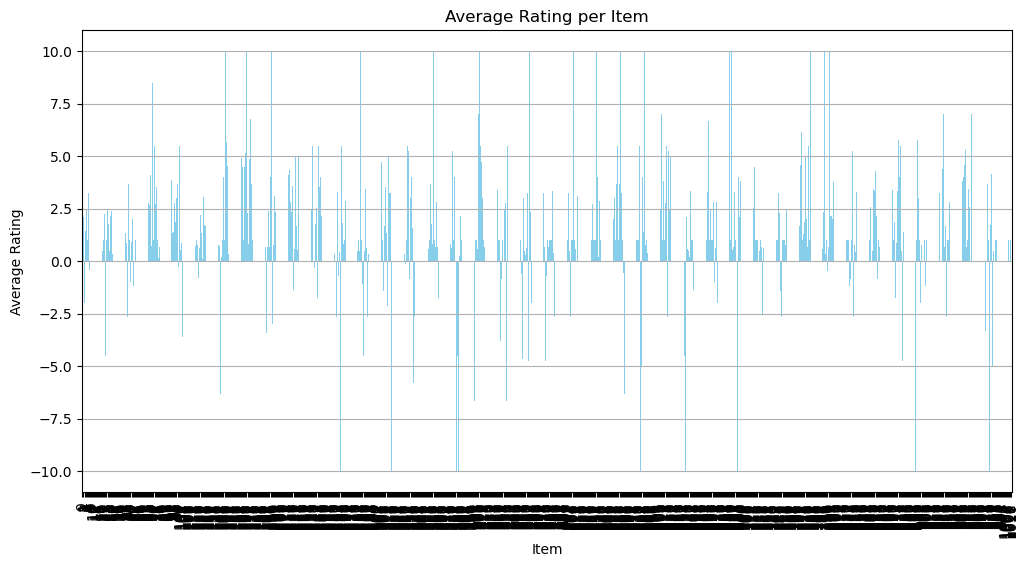

In [320]:
# Calculate average rating per item
average_ratings = anom1_df.groupby('item')['rating'].mean()

# Plotting
plt.figure(figsize=(12, 6))
average_ratings.plot(kind='bar', color='skyblue')
plt.title('Average Rating per Item')
plt.xlabel('Item')
plt.ylabel('Average Rating')
plt.grid(axis='y')
plt.show()

In [321]:
anom2_df = merged_df[merged_df['label'] == 2]
print(anom2_df.count())
anom2_df.head()

user      8585
item      8585
rating    8585
label     8585
dtype: int64


,user,item,rating,label
171171,52,0,-10,2
171172,52,1,1,2
171173,52,9,1,2
171174,52,10,1,2
171175,52,13,1,2


In [322]:
# Get unique values in the 'item' column
unique_items = anom1_df['user'].unique()

# Display the result
print('Unique items:', unique_items)

Unique items: [ 876 1095  611  419  256  972   78  858  180  137  567  270  443  695
   22  447  226  439 1056  474  494  500  522 1067  247  445  585   10
  110  424  339  790  865 1098  481  161  869  337  290  571  763  613
  608  588  568  232 1069  268  855  819]


In [323]:
# Get unique values in the 'item' column
unique_items = anom2_df['user'].unique()

# Display the result
print('Unique items:', unique_items)

Unique items: [  52  325  130  366  124  423  895  795  663  164  990  373 1026  914
  987  245   30  772  502  415 1092 1093  715   82  692   20  365  826
  661  478  216  441  713  491  487  804 1066   39  643 1059  748  347
  623  533  769  246  950  264   23  793]


In [324]:
user23 = merged_df[merged_df['user']== 130]

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Print the DataFrame
print(user23)

# Reset display options if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

        user  item  rating  label
171447   130     4      10      2
171448   130     7       1      2
171449   130    11       1      2
171450   130    13       1      2
171451   130    18       1      2
171452   130    20       1      2
171453   130    22       1      2
171454   130    23     -10      2
171455   130    24       1      2
171456   130    27      10      2
171457   130    29       1      2
171458   130    36       1      2
171459   130    44       1      2
171460   130    46       1      2
171461   130    47       1      2
171462   130    55       1      2
171463   130    57       1      2
171464   130    59     -10      2
171465   130    60     -10      2
171466   130    65      10      2
171467   130    66      10      2
171468   130    67       0      2
171469   130    70       1      2
171470   130    72       1      2
171471   130    73     -10      2
171472   130    77       0      2
171473   130    78       1      2
171474   130    81       1      2
171475   130  

In [325]:
#1.24609375
# Calculate the average rating
average_rating = user23['rating'].mean()
total_rating = user23['rating'].sum()
# Display the result
print(f'Average Rating: {average_rating}')
print(f'Total Rating: {total_rating}')

Average Rating: 0.05660377358490566
Total Rating: 3


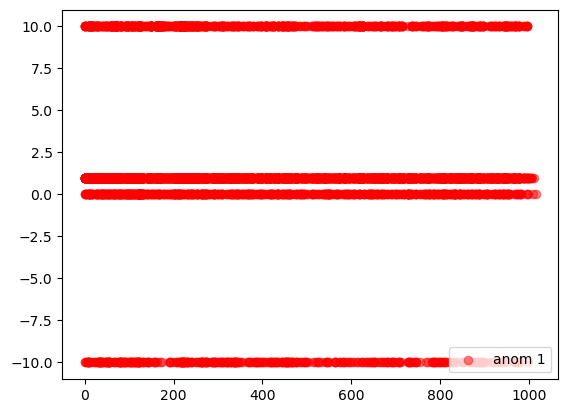

In [326]:
import matplotlib.pyplot as plt

plt.scatter(x=anom1_df['item'], y=anom1_df['rating'] ,c='r', alpha= 0.45 , label='anom 1')
plt.legend()

In [327]:
user_stats = merged_df.groupby('user')['rating'].agg(['mean', 'sum', 'count']).reset_index()
user_stats.columns = ['user', 'mean_rating', 'total_rating', 'rating_count']
df = merged_df.merge(user_stats, on='user', how='left')

unique_label_count = df['label'].nunique()
print(f'Number of unique label: {unique_label_count}')
df.head()

Number of unique label: 3


,user,item,rating,label,mean_rating,total_rating,rating_count
0,1073,3,1,0,2.962963,80,27
1,1073,15,1,0,2.962963,80,27
2,1073,24,1,0,2.962963,80,27
3,1073,29,1,0,2.962963,80,27
4,1073,33,10,0,2.962963,80,27


In [328]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


y = df['label']
X = df.drop('label', axis=1)
print(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# Print classification report
print(classification_report(y_test, y_pred))

        user  item  rating  mean_rating  total_rating  rating_count
0       1073     3       1     2.962963            80            27
1       1073    15       1     2.962963            80            27
2       1073    24       1     2.962963            80            27
3       1073    29       1     2.962963            80            27
4       1073    33      10     2.962963            80            27
...      ...   ...     ...          ...           ...           ...
179751   793   845     -10    -1.480000           -37            25
179752   793   854       1    -1.480000           -37            25
179753   793   862       1    -1.480000           -37            25
179754   793   886       1    -1.480000           -37            25
179755   793   890       1    -1.480000           -37            25

[179756 rows x 6 columns]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33238
           1       1.00      1.00      1.00     

In [329]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred_proba = model.predict_proba(X_test)

# Calculate AUC for multi-class (One-vs-Rest)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

# Print AUC
print(f'Area Under Curve (AUC): {auc:.2f}')

Area Under Curve (AUC): 1.00


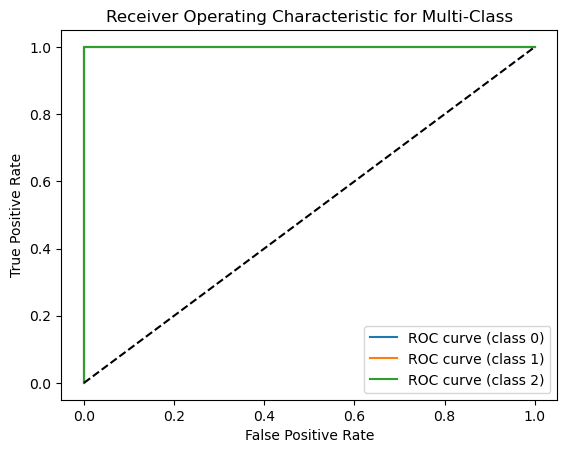

In [330]:
# Calculate ROC curve for each class
n_classes = len(np.unique(y))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'ROC curve (class {i})')

# Add ROC curve diagonal
plt.plot([0, 1], [0, 1], 'k--')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc='lower right')
plt.show()

In [337]:
# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_pred
})

# Display the comparison DataFrame
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Print the DataFrame
print(comparison_df)

# Reset display options if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

unique_label_count = comparison_df['Predicted Label'].nunique()
print(f'Number of unique label: {unique_label_count}')

        True Label  Predicted Label
149135           0                0
36428            0                0
10733            0                0
62483            0                0
19073            0                0
57432            0                0
18084            0                0
118155           0                0
58752            0                0
106672           0                0
138162           0                0
59645            0                0
38678            0                0
50681            0                0
166943           1                1
49395            0                0
72563            0                0
176812           2                2
86943            0                0
157596           0                0
176962           2                2
144099           0                0
92792            0                0
64235            0                0
36446            0                0
154347           0                0
79115            0          

In [332]:
# Count correct and incorrect predictions
correct_predictions = (comparison_df['True Label'] == comparison_df['Predicted Label']).sum()
total_predictions = len(comparison_df)

print(f'Correct Predictions: {correct_predictions}')
print(f'Total Predictions: {total_predictions}')
print(f'Accuracy: {correct_predictions / total_predictions:.2f}')

Correct Predictions: 35952
Total Predictions: 35952
Accuracy: 1.00


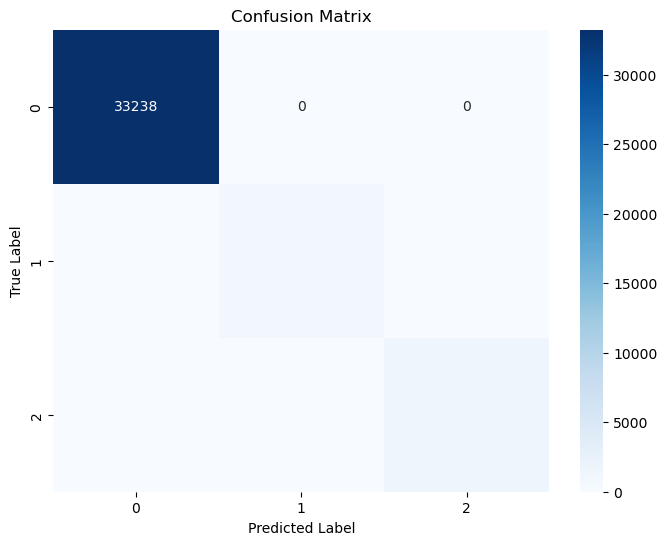

In [333]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [339]:
# Create a DataFrame for predictions
predictions_df = pd.DataFrame({
    'Predicted Label': y_pred
})

# Add a user identifier column (you may need to adjust this based on how you align predictions to users)
predictions_df['user'] = df['user'].iloc[:len(y_pred)].values  # Align with the original user entries

# Display the predictions with users
print(predictions_df)

# Group by user to see predictions per user
user_predictions = predictions_df.groupby('user')['Predicted Label'].apply(list).reset_index()

# Display user predictions
print(user_predictions)


       Predicted Label  user
0                    0  1073
1                    0  1073
2                    0  1073
3                    0  1073
4                    0  1073
...                ...   ...
35947                0   521
35948                0   521
35949                0   521
35950                0   521
35951                0   521

[35952 rows x 2 columns]
     user                                    Predicted Label
0       5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...
1       9  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2      12  [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...
3      24  [0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, ...
4      25  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
..    ...                                                ...
210  1078  [0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ...
211  1084  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
212  1087  [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
213  1090      [

In [ ]:
# Aggregate to get the most common predicted label for each user
final_predictions = predictions_df.groupby('User')['Predicted Label'].agg(lambda x: x.mode()[0]).reset_index()

# Display the final predictions
print(final_predictions)


In [ ]:
# Merge actual labels with predicted labels
comparison_df = pd.merge(yy, final_predictions, on='User')

# Display the comparison DataFrame
print(comparison_df)


In [ ]:
# Count correct predictions
comparison_df['Correct'] = comparison_df['Actual Label'] == comparison_df['Predicted Label']
correct_predictions = comparison_df['Correct'].sum()
total_predictions = len(comparison_df)

print(f'Correct Predictions: {correct_predictions}')
print(f'Total Predictions: {total_predictions}')
print(f'Accuracy: {correct_predictions / total_predictions:.2f}')
